In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from Lung_dataset import ILDDataset

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [13]:
NUM_TOTAL = 1982
NUM_TRAIN = 1500
#add path as absolute path for root dir

im_size = 128

lung_dataset_train = ILDDataset(csv_file='/Users/magdy/Desktop/Stanford Spring/BMI260/Project/Data/Clean_train_test_dataset/Dataset/train_labels.csv',
                          root_dir='/Users/magdy/Desktop/Stanford Spring/BMI260/Project/Data/Clean_train_test_dataset/Dataset/train',
                          mask=True, HU=True, resize=128)

#add path as absolute path for root dir
lung_dataset_test = ILDDataset(csv_file='/Users/magdy/Desktop/Stanford Spring/BMI260/Project/Data/Clean_train_test_dataset/Dataset/test_labels.csv',
                          root_dir='/Users/magdy/Desktop/Stanford Spring/BMI260/Project/Data/Clean_train_test_dataset/Dataset/test',
                          mask=True, HU=True, resize=128)

loader_train = DataLoader(lung_dataset_train, batch_size=32, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=32, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=32)

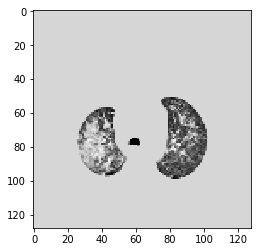

label: 2


In [14]:
#show datasample
sample = lung_dataset_train[120]
plt.imshow(sample[0], cmap='gray')
plt.show()
print("label: " + str(sample[1]))

In [15]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


In [16]:
def get_model(freeze=False):
    """
    Used to fetch model for classification
    """

    num_classes = 3

    model = models.resnet50(pretrained=True)
    model.avgpool = nn.AvgPool2d(1, stride=1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
    if(freeze==True):
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(32768, num_classes)
    
    return model
    

In [17]:
def check_accuracy(loader, model, train=False):
    if loader.dataset.train and train == True:
        print('Checking accuracy on training set')
    elif loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x.unsqueeze_(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples      
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
    return acc
 

In [18]:
def train(model, optimizer, epochs=1, overfit=False):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_acc = 0;
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            
            #38,16,46
            weights = torch.tensor([1,1, 1], device= device, dtype=dtype)
            x.unsqueeze_(1)
            scores = model(x)
            Loss = nn.CrossEntropyLoss(weight = weights)
            loss = Loss(scores, y)
            
            
            reg = torch.tensor(1e-2, device= device, dtype=dtype)
            l2_reg = torch.tensor(0. , device= device, dtype=dtype)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += reg * l2_reg

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                if(overfit):
                    _ = check_accuracy(loader_train, model, train=True)
                acc = check_accuracy(loader_val, model)
                if acc > best_acc:
                        best_acc = acc
                        best_model = model
                print()
    return best_model

In [ ]:
model1 = get_model()
optimizer = optim.Adam(model1.parameters(), lr = 0.0001, weight_decay= 1e-5)
best_model = train(model1, optimizer, epochs=10, overfit=True)

Iteration 0, loss = 9.4315
Checking accuracy on test set
Got 641 / 1500 correct (42.73)
Checking accuracy on test set
Got 311 / 482 correct (64.52)

Iteration 0, loss = 8.7697
Checking accuracy on test set
Got 1150 / 1500 correct (76.67)
Checking accuracy on test set
Got 201 / 482 correct (41.70)

Iteration 0, loss = 8.4266
Checking accuracy on test set
Got 1338 / 1500 correct (89.20)
Checking accuracy on test set
Got 326 / 482 correct (67.63)

Iteration 0, loss = 8.2821
Checking accuracy on test set
Got 1415 / 1500 correct (94.33)
Checking accuracy on test set
Got 278 / 482 correct (57.68)

Iteration 0, loss = 8.3116
Checking accuracy on test set
Got 1226 / 1500 correct (81.73)
Checking accuracy on test set
Got 284 / 482 correct (58.92)



In [17]:
#Check Test set
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got 166 / 375 correct (44.27)


0.44266666666666665